In [1]:
from Utility05_Bayesian import *
# from bayes_opt import BayesianOptimization
from tiramisu_net import *
import scipy.io
import cv2
import multiprocessing

Using TensorFlow backend.


In [2]:
Model_set_id=1

In [3]:
def make_di_path(path_name):
    try:
        os.mkdir(path_name)
    except OSError:
        print ("Creation of the directory %s failed" % path_name)
    else:
        print ("Successfully created the directory %s " % path_name)    

In [4]:
path_name="case_study_models"+'\\'+'Model set-'+str(Model_set_id).zfill(2)
make_di_path(path_name)
Model_dir=path_name+'\\'

Creation of the directory case_study_models\Model set-01 failed


In [5]:
import os, shutil
folder = Model_dir
for the_file in os.listdir(folder):
    file_path = os.path.join(folder, the_file)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
        #elif os.path.isdir(file_path): shutil.rmtree(file_path)
    except Exception as e:
        print(e)

In [6]:
new_H=180
new_W=320
N_MCS=20

## Structure data

In [7]:
MFW_data=np.load('MFW_data.npz')

pixel_unique=MFW_data['pixel_unique']
pixel_count=MFW_data['pixel_count']
class_weights_freq=MFW_data['class_weights_freq']

print('pixel_unique:')
print(pixel_unique)

print('pixel_count:')
pixel_count[1]=sum(pixel_count[1:])
pixel_count=pixel_count[0:2]
print(pixel_count)
pixel_med=np.median(pixel_count)
class_weights_freq=pixel_med/pixel_count

print('class_weights_freq:')
print(class_weights_freq)

pixel_unique:
[1 2 3 4 5]
pixel_count:
[761355002  68084998]
class_weights_freq:
[0.54471304 6.0912097 ]


In [8]:
class Ego_data_split:
    
    def __init__(self,set_dir,n_obs,new_H=new_H,new_W=new_W):
        self.n_obs = n_obs
        self.set_dir = set_dir
        self.new_H = new_H
        self.new_W = new_W        

    def resize_data(data):
        
        return data_res
    
    def load_data(self,image_id, resize=True,verbose=0,
                  norm_RGB=255):
        mask_i = scipy.io.loadmat(self.set_dir+'/hand_mask_'+str(image_id+1)+'.mat')['hand_mask']
        img_i = scipy.io.loadmat(self.set_dir+'/img_'+str(image_id+1)+'.mat')['img']/norm_RGB
        
        if resize:
            mask_i = cv2.resize(np.array(mask_i), (self.new_W,self.new_H), interpolation =cv2.INTER_NEAREST)
            img_i = cv2.resize(np.array(img_i), (self.new_W,self.new_H), interpolation =cv2.INTER_NEAREST)
            
        if verbose==1:
            print('img_i.shape:  '+str(mask_i.shape))
            print('mask_i.shape: '+str(mask_i.shape))
            
        return mask_i,img_i    

In [9]:
training_set=Ego_data_split('../../dataset/01_train',3600)
val_set=Ego_data_split('../../dataset/02_val',400)
test_set=Ego_data_split('../../dataset/03_test',800)

In [10]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, set_dir, n_obs, class_weights, batch_size,
                 n_classes=2, shuffle=True, new_H=new_H, new_W=new_W):
        'Initialization'
        self.set_dir = set_dir
        self.batch_size = batch_size
        self.class_weights = class_weights
        self.n_obs = n_obs
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        self.new_H = new_H
        self.new_W = new_W

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.n_obs / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        data_tuple = self.__data_generation(indexes)

        return data_tuple

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.n_obs)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, self.new_H,self.new_W, 3))
        y = np.empty((self.batch_size, self.new_H,self.new_W), dtype=int)

        # Generate data
        for i, ID in enumerate(indexes):
            # Store sample
            img_i = scipy.io.loadmat(self.set_dir+'/img_'+str(ID+1)+'.mat')['img']/255
            X[i,] = cv2.resize(np.array(img_i), (self.new_W,self.new_H), interpolation =cv2.INTER_NEAREST)
            
            # Store class
            mask_i = scipy.io.loadmat(self.set_dir+'/hand_mask_'+str(ID+1)+'.mat')['hand_mask']
            y[i] = cv2.resize(np.array(mask_i), (self.new_W,self.new_H), interpolation =cv2.INTER_NEAREST)-1
         
        y[y>1]=1
        y_resh=y.reshape((-1,self.new_H*self.new_W))
#         print(np.amax(y_resh))
#         print(y_resh.shape)
        y_cat=keras.utils.to_categorical(y_resh, num_classes=self.n_classes)
        batch_wieghts = gen_weight_mat(y,self.class_weights)
        

        return (X, y_cat,batch_wieghts)

## Inference

In [11]:
import tensorflow as tf

In [12]:
# graph1 = tf.Graph()
# with graph1.as_default():
#     session1 = tf.Session()
#     with session1.as_default():
#         main_model=load_model('test.h5')
# print('main model loaded')    

# graph2 = tf.Graph()
# with graph2.as_default():
#     session2 = tf.Session()
#     with session2.as_default():
#         SRG_model=load_model('test_SRG.h5')
        
# print('SRG model loaded') 

In [13]:
class Model:
    @staticmethod
    def loadmodel(path):
        return load_model(path)

    def __init__(self, path):
        self.model = self.loadmodel(path)
        self.graph = tf.get_default_graph()

    def predict(self, X):
        with self.graph.as_default():
            return self.model.predict(X)

In [14]:
main_model=Model('test.h5')
SRG_model=Model('test_SRG.h5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [15]:
def Monty_Model_softmax_X(X,model, N_MCS):
    SoftMaxBin_list=[]
    for i in range(N_MCS):
        SoftMaxBin_list.append(model.predict(X))
    SoftMaxBin=np.array(SoftMaxBin_list)
    
    SoftmaxMean=np.mean(SoftMaxBin,axis=0)
    SoftmaxStd=np.std(SoftMaxBin,axis=0)

    return SoftmaxMean,SoftmaxStd

In [16]:
import glob
def get_Y(set_dir,new_H=new_H,new_W=new_W):
    obs_dir=glob.glob(set_dir+'/hand_mask_*')
    n_obs_set=len(obs_dir)
    y=np.empty((n_obs_set, new_H,new_W), dtype=int)
    for i_obs in range(n_obs_set):
        mask_i = scipy.io.loadmat(set_dir+'/hand_mask_'+str(i_obs+1)+'.mat')['hand_mask']
        y[i_obs] = cv2.resize(np.array(mask_i), (new_W,new_H), interpolation =cv2.INTER_NEAREST)-1

    y[y>1]=1
#     y_resh=y.reshape((-1,new_H*new_W))
    print(y.shape)
    return y

In [17]:
# y_gt_test=get_Y('../../dataset/03_test')

### Visualization

In [18]:
import time

N_MCS_main=20
N_MCS_SRG=1

Obs. 1 processed, t_load: 0.045, t_MCS: 0.585, t_ENTP: 0.002, t_inSRG: 0.002, t_SRG: 0.110 t_sum= 0.743 (s)


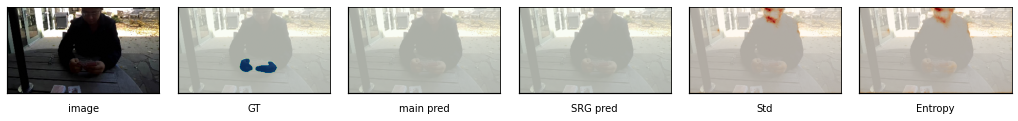

Obs. 11 processed, t_load: 0.046, t_MCS: 0.526, t_ENTP: 0.002, t_inSRG: 0.002, t_SRG: 0.096 t_sum= 0.672 (s)


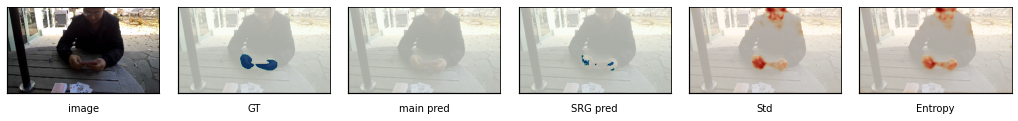

Obs. 21 processed, t_load: 0.044, t_MCS: 0.546, t_ENTP: 0.003, t_inSRG: 0.002, t_SRG: 0.098 t_sum= 0.693 (s)


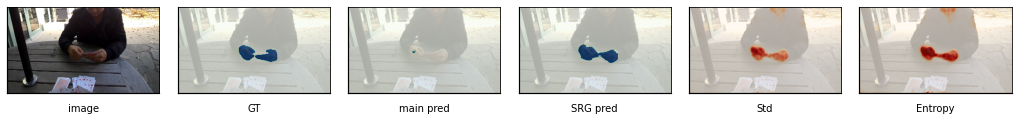

Obs. 31 processed, t_load: 0.044, t_MCS: 0.537, t_ENTP: 0.003, t_inSRG: 0.001, t_SRG: 0.099 t_sum= 0.684 (s)


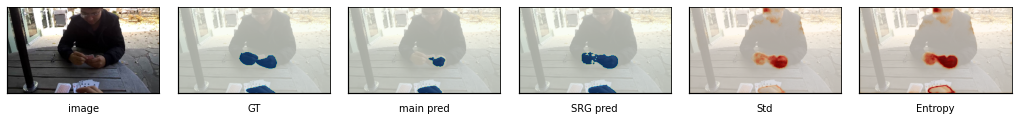

Obs. 41 processed, t_load: 0.045, t_MCS: 0.559, t_ENTP: 0.006, t_inSRG: 0.002, t_SRG: 0.101 t_sum= 0.713 (s)


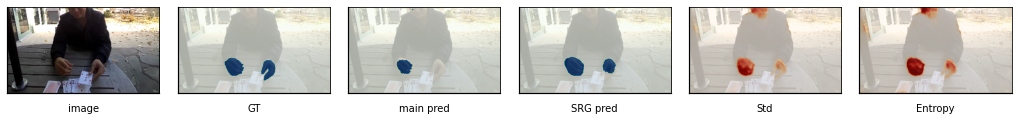

Obs. 51 processed, t_load: 0.045, t_MCS: 0.551, t_ENTP: 0.002, t_inSRG: 0.002, t_SRG: 0.102 t_sum= 0.701 (s)


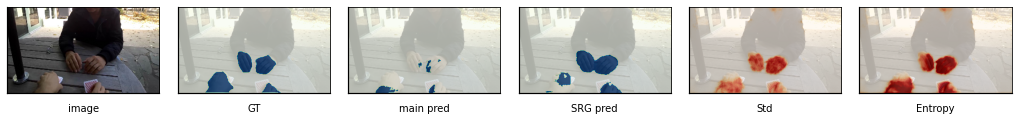

Obs. 61 processed, t_load: 0.046, t_MCS: 0.568, t_ENTP: 0.007, t_inSRG: 0.002, t_SRG: 0.097 t_sum= 0.719 (s)


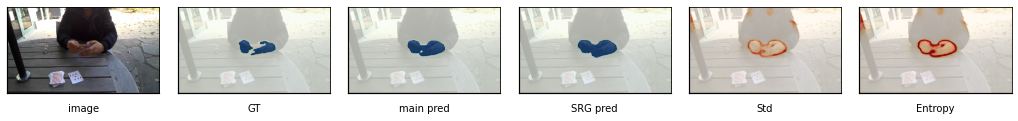

Obs. 71 processed, t_load: 0.046, t_MCS: 0.518, t_ENTP: 0.002, t_inSRG: 0.002, t_SRG: 0.099 t_sum= 0.667 (s)


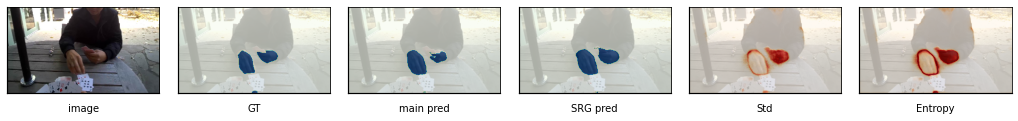

Obs. 81 processed, t_load: 0.045, t_MCS: 0.560, t_ENTP: 0.008, t_inSRG: 0.005, t_SRG: 0.099 t_sum= 0.716 (s)


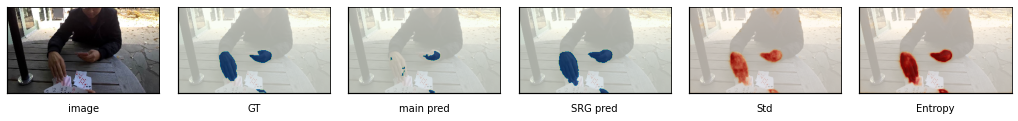

Obs. 91 processed, t_load: 0.047, t_MCS: 0.575, t_ENTP: 0.005, t_inSRG: 0.002, t_SRG: 0.104 t_sum= 0.732 (s)


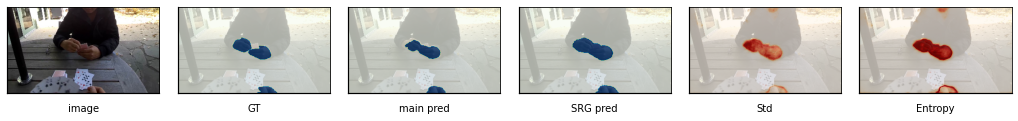

Obs. 101 processed, t_load: 0.046, t_MCS: 0.537, t_ENTP: 0.002, t_inSRG: 0.002, t_SRG: 0.101 t_sum= 0.688 (s)


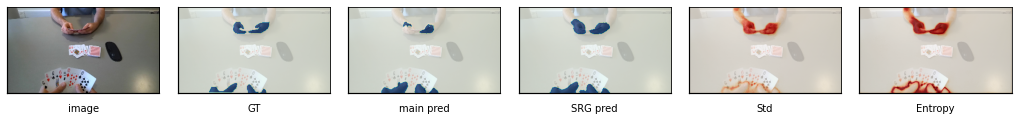

Obs. 111 processed, t_load: 0.047, t_MCS: 0.539, t_ENTP: 0.008, t_inSRG: 0.005, t_SRG: 0.104 t_sum= 0.702 (s)


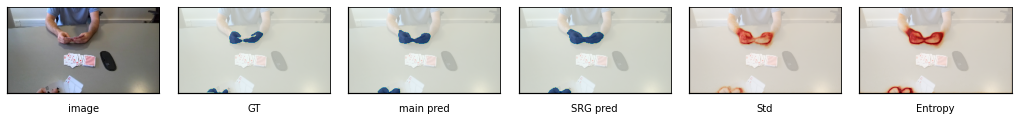

Obs. 121 processed, t_load: 0.044, t_MCS: 0.538, t_ENTP: 0.002, t_inSRG: 0.002, t_SRG: 0.100 t_sum= 0.686 (s)


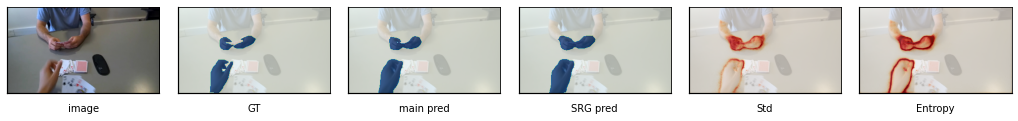

Obs. 131 processed, t_load: 0.045, t_MCS: 0.560, t_ENTP: 0.002, t_inSRG: 0.002, t_SRG: 0.107 t_sum= 0.715 (s)


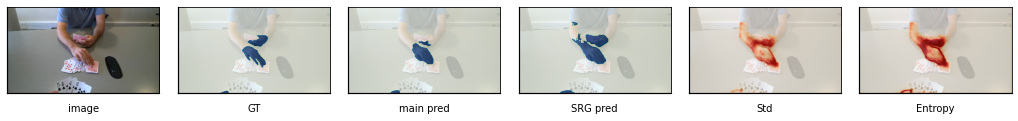

Obs. 141 processed, t_load: 0.043, t_MCS: 0.554, t_ENTP: 0.003, t_inSRG: 0.001, t_SRG: 0.096 t_sum= 0.696 (s)


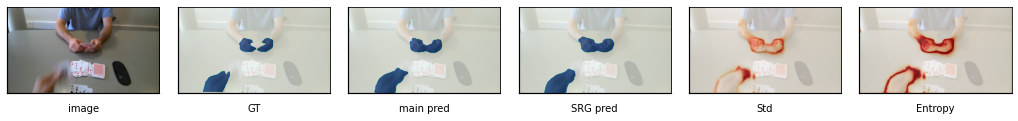

Obs. 151 processed, t_load: 0.045, t_MCS: 0.532, t_ENTP: 0.002, t_inSRG: 0.002, t_SRG: 0.100 t_sum= 0.680 (s)


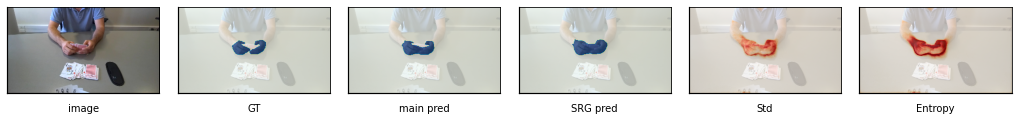

Obs. 161 processed, t_load: 0.047, t_MCS: 0.527, t_ENTP: 0.003, t_inSRG: 0.001, t_SRG: 0.097 t_sum= 0.674 (s)


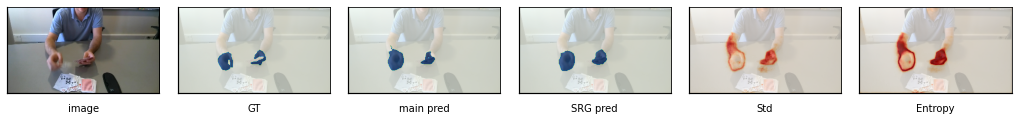

Obs. 171 processed, t_load: 0.042, t_MCS: 0.526, t_ENTP: 0.003, t_inSRG: 0.001, t_SRG: 0.098 t_sum= 0.670 (s)


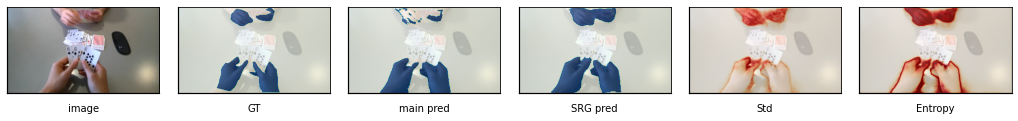

Obs. 181 processed, t_load: 0.044, t_MCS: 0.633, t_ENTP: 0.007, t_inSRG: 0.002, t_SRG: 0.110 t_sum= 0.796 (s)


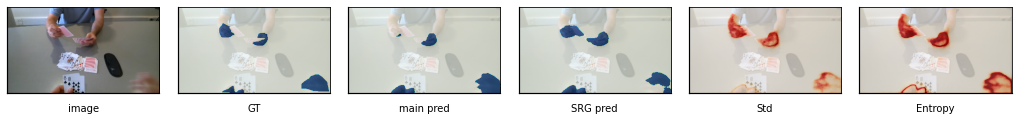

Obs. 191 processed, t_load: 0.049, t_MCS: 0.572, t_ENTP: 0.008, t_inSRG: 0.003, t_SRG: 0.108 t_sum= 0.740 (s)


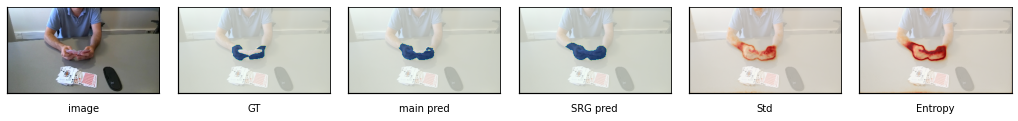

Obs. 201 processed, t_load: 0.044, t_MCS: 0.525, t_ENTP: 0.002, t_inSRG: 0.002, t_SRG: 0.096 t_sum= 0.669 (s)


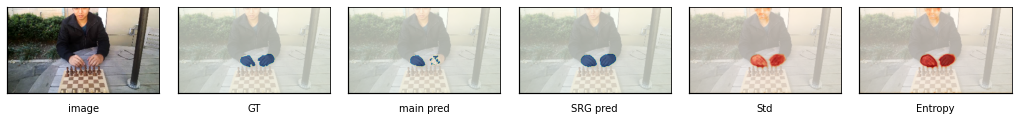

Obs. 211 processed, t_load: 0.047, t_MCS: 0.523, t_ENTP: 0.003, t_inSRG: 0.002, t_SRG: 0.100 t_sum= 0.674 (s)


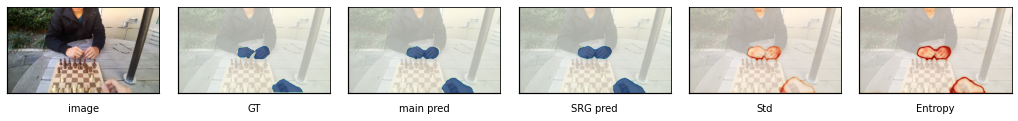

Obs. 221 processed, t_load: 0.047, t_MCS: 0.530, t_ENTP: 0.002, t_inSRG: 0.002, t_SRG: 0.097 t_sum= 0.678 (s)


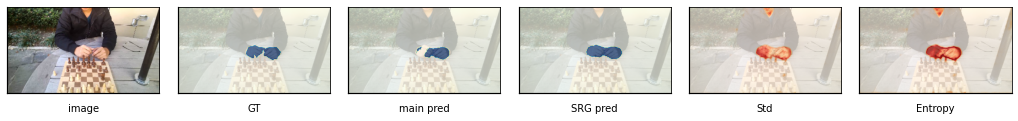

Obs. 231 processed, t_load: 0.046, t_MCS: 0.604, t_ENTP: 0.002, t_inSRG: 0.002, t_SRG: 0.103 t_sum= 0.757 (s)


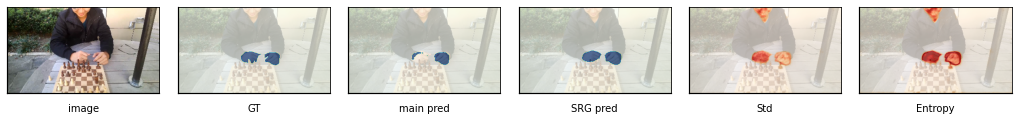

Obs. 241 processed, t_load: 0.045, t_MCS: 0.551, t_ENTP: 0.003, t_inSRG: 0.002, t_SRG: 0.110 t_sum= 0.711 (s)


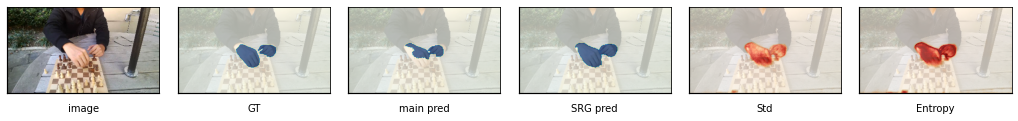

Obs. 251 processed, t_load: 0.048, t_MCS: 0.565, t_ENTP: 0.002, t_inSRG: 0.002, t_SRG: 0.098 t_sum= 0.715 (s)


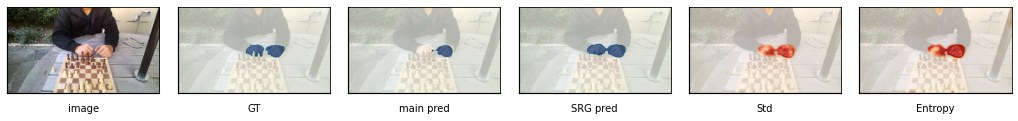

Obs. 261 processed, t_load: 0.048, t_MCS: 0.550, t_ENTP: 0.003, t_inSRG: 0.001, t_SRG: 0.099 t_sum= 0.700 (s)


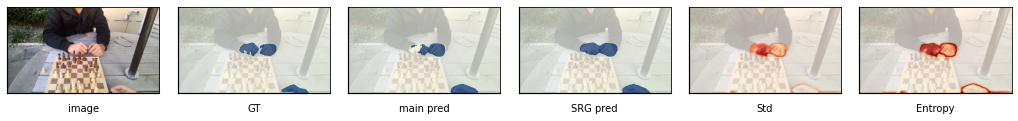

Obs. 271 processed, t_load: 0.045, t_MCS: 0.513, t_ENTP: 0.002, t_inSRG: 0.002, t_SRG: 0.095 t_sum= 0.656 (s)


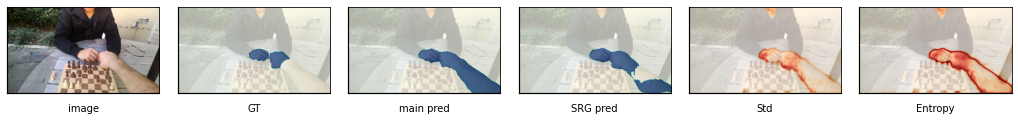

Obs. 281 processed, t_load: 0.046, t_MCS: 0.524, t_ENTP: 0.002, t_inSRG: 0.002, t_SRG: 0.103 t_sum= 0.677 (s)


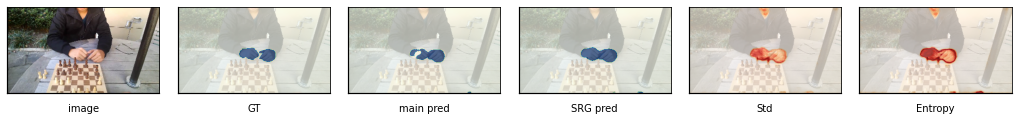

Obs. 291 processed, t_load: 0.045, t_MCS: 0.597, t_ENTP: 0.008, t_inSRG: 0.005, t_SRG: 0.107 t_sum= 0.762 (s)


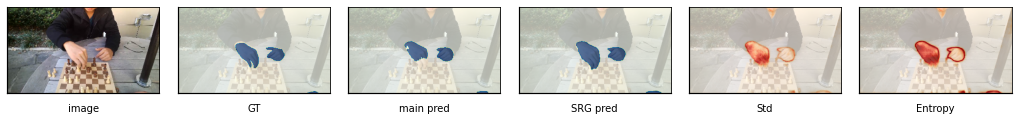

Obs. 301 processed, t_load: 0.050, t_MCS: 0.617, t_ENTP: 0.004, t_inSRG: 0.002, t_SRG: 0.109 t_sum= 0.781 (s)


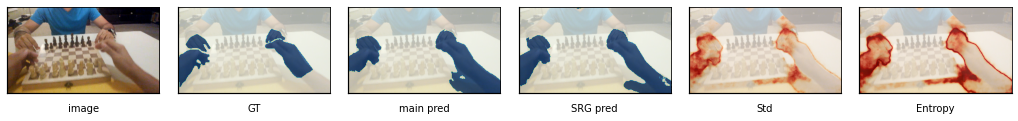

Obs. 311 processed, t_load: 0.047, t_MCS: 0.586, t_ENTP: 0.002, t_inSRG: 0.002, t_SRG: 0.095 t_sum= 0.732 (s)


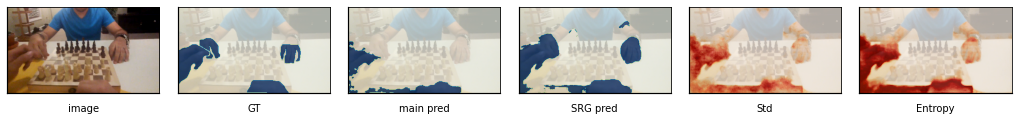

Obs. 321 processed, t_load: 0.048, t_MCS: 0.560, t_ENTP: 0.002, t_inSRG: 0.002, t_SRG: 0.102 t_sum= 0.713 (s)


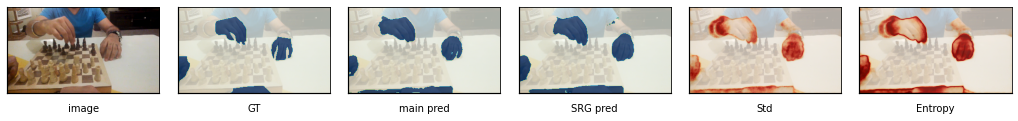

Obs. 331 processed, t_load: 0.048, t_MCS: 0.533, t_ENTP: 0.003, t_inSRG: 0.001, t_SRG: 0.097 t_sum= 0.681 (s)


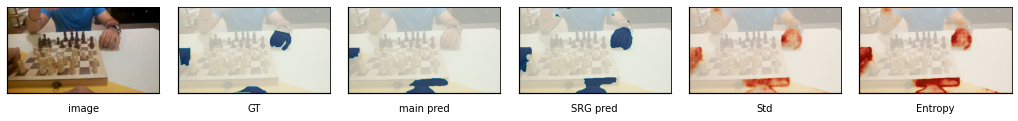

Obs. 341 processed, t_load: 0.046, t_MCS: 0.548, t_ENTP: 0.003, t_inSRG: 0.002, t_SRG: 0.096 t_sum= 0.695 (s)


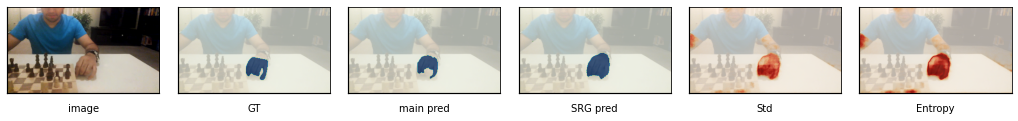

Obs. 351 processed, t_load: 0.046, t_MCS: 0.540, t_ENTP: 0.002, t_inSRG: 0.002, t_SRG: 0.098 t_sum= 0.687 (s)


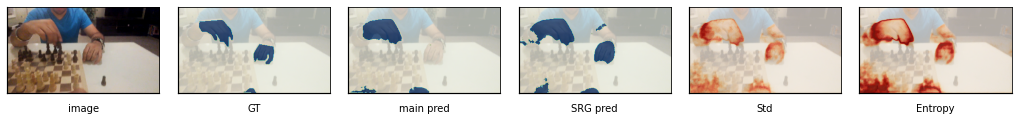

Obs. 361 processed, t_load: 0.048, t_MCS: 0.541, t_ENTP: 0.008, t_inSRG: 0.004, t_SRG: 0.099 t_sum= 0.699 (s)


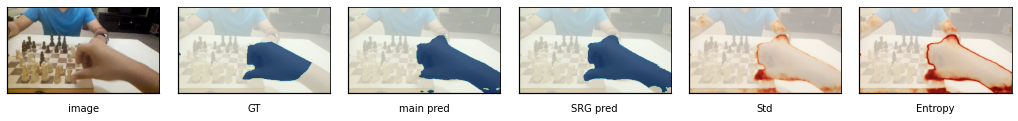

Obs. 371 processed, t_load: 0.047, t_MCS: 0.525, t_ENTP: 0.002, t_inSRG: 0.002, t_SRG: 0.099 t_sum= 0.675 (s)


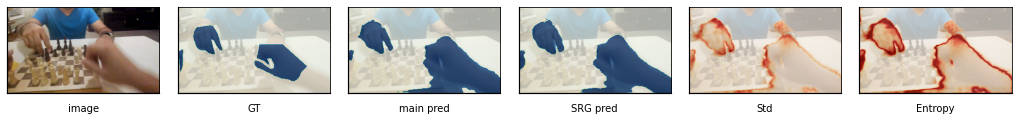

Obs. 381 processed, t_load: 0.048, t_MCS: 0.540, t_ENTP: 0.003, t_inSRG: 0.002, t_SRG: 0.098 t_sum= 0.691 (s)


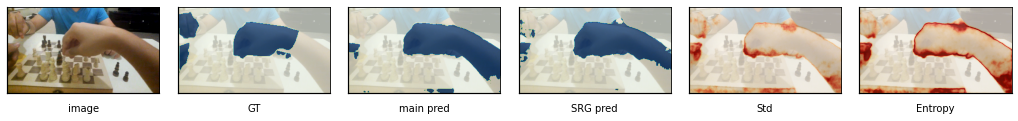

Obs. 391 processed, t_load: 0.046, t_MCS: 0.524, t_ENTP: 0.003, t_inSRG: 0.002, t_SRG: 0.098 t_sum= 0.673 (s)


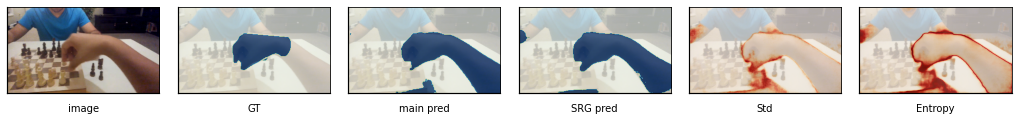

Obs. 401 processed, t_load: 0.046, t_MCS: 0.559, t_ENTP: 0.008, t_inSRG: 0.005, t_SRG: 0.098 t_sum= 0.716 (s)


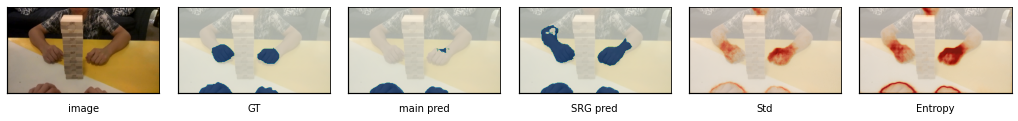

Obs. 411 processed, t_load: 0.047, t_MCS: 0.537, t_ENTP: 0.002, t_inSRG: 0.002, t_SRG: 0.097 t_sum= 0.684 (s)


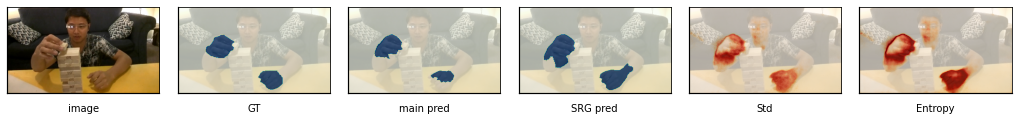

Obs. 421 processed, t_load: 0.044, t_MCS: 0.533, t_ENTP: 0.003, t_inSRG: 0.001, t_SRG: 0.101 t_sum= 0.682 (s)


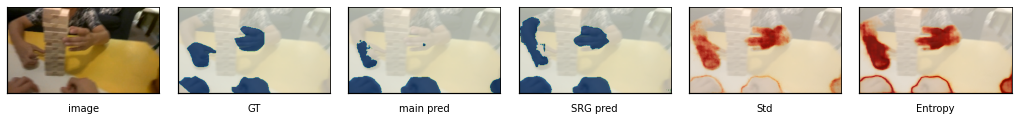

Obs. 431 processed, t_load: 0.044, t_MCS: 0.535, t_ENTP: 0.003, t_inSRG: 0.001, t_SRG: 0.098 t_sum= 0.680 (s)


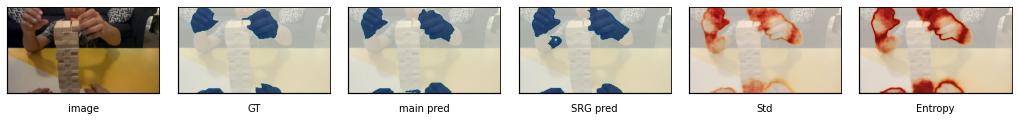

Obs. 441 processed, t_load: 0.044, t_MCS: 0.532, t_ENTP: 0.007, t_inSRG: 0.002, t_SRG: 0.100 t_sum= 0.685 (s)


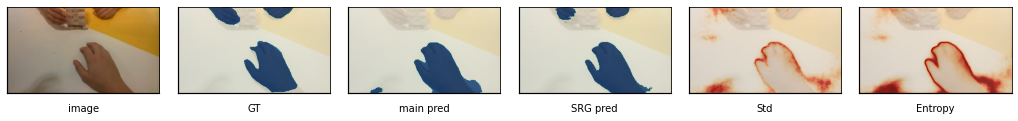

Obs. 451 processed, t_load: 0.047, t_MCS: 0.534, t_ENTP: 0.002, t_inSRG: 0.002, t_SRG: 0.096 t_sum= 0.681 (s)


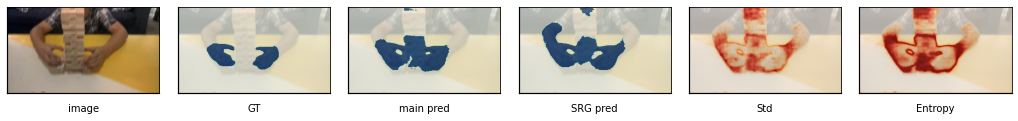

Obs. 461 processed, t_load: 0.045, t_MCS: 0.524, t_ENTP: 0.002, t_inSRG: 0.002, t_SRG: 0.099 t_sum= 0.671 (s)


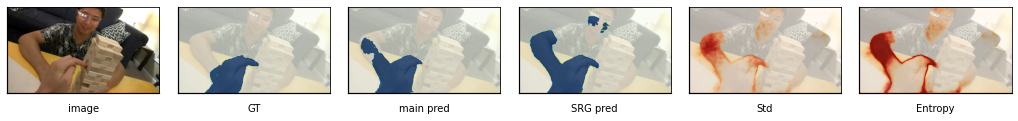

Obs. 471 processed, t_load: 0.046, t_MCS: 0.534, t_ENTP: 0.002, t_inSRG: 0.002, t_SRG: 0.097 t_sum= 0.681 (s)


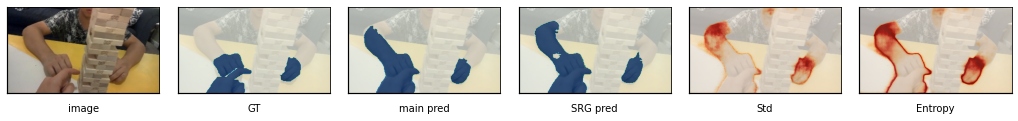

Obs. 481 processed, t_load: 0.047, t_MCS: 0.525, t_ENTP: 0.002, t_inSRG: 0.002, t_SRG: 0.098 t_sum= 0.674 (s)


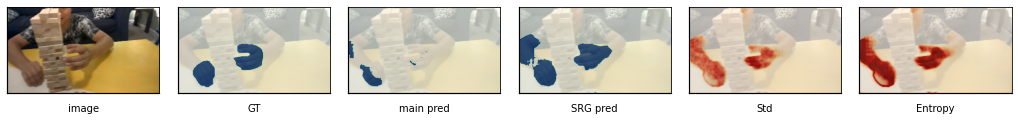

Obs. 491 processed, t_load: 0.044, t_MCS: 0.558, t_ENTP: 0.002, t_inSRG: 0.002, t_SRG: 0.099 t_sum= 0.705 (s)


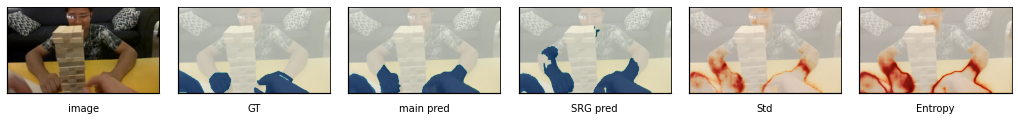

Obs. 501 processed, t_load: 0.046, t_MCS: 0.531, t_ENTP: 0.003, t_inSRG: 0.002, t_SRG: 0.101 t_sum= 0.682 (s)


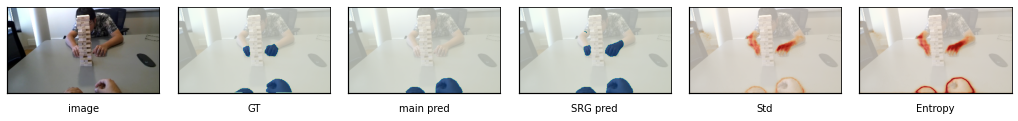

Obs. 511 processed, t_load: 0.065, t_MCS: 0.531, t_ENTP: 0.003, t_inSRG: 0.002, t_SRG: 0.101 t_sum= 0.702 (s)


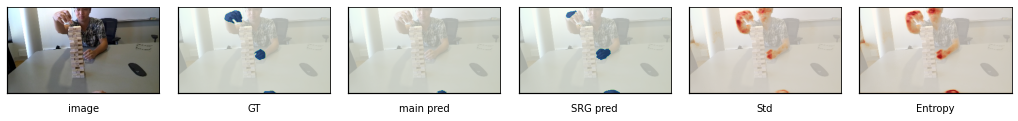

Obs. 521 processed, t_load: 0.069, t_MCS: 0.526, t_ENTP: 0.002, t_inSRG: 0.002, t_SRG: 0.104 t_sum= 0.702 (s)


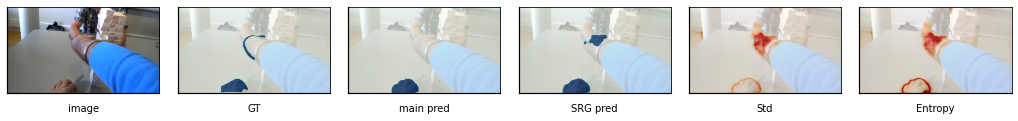

Obs. 531 processed, t_load: 0.046, t_MCS: 0.546, t_ENTP: 0.003, t_inSRG: 0.001, t_SRG: 0.102 t_sum= 0.698 (s)


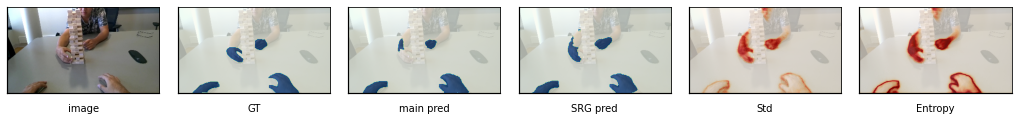

Obs. 541 processed, t_load: 0.046, t_MCS: 0.538, t_ENTP: 0.008, t_inSRG: 0.005, t_SRG: 0.096 t_sum= 0.693 (s)


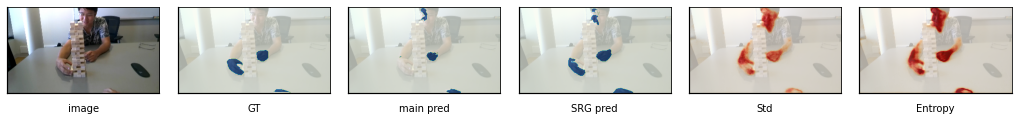

Obs. 551 processed, t_load: 0.044, t_MCS: 0.560, t_ENTP: 0.008, t_inSRG: 0.003, t_SRG: 0.096 t_sum= 0.711 (s)


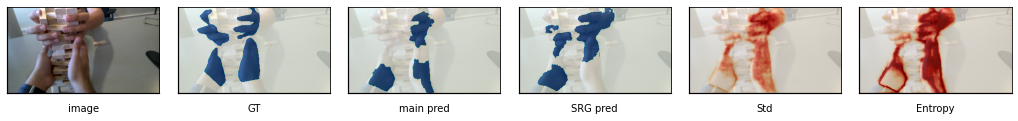

Obs. 561 processed, t_load: 0.076, t_MCS: 0.569, t_ENTP: 0.007, t_inSRG: 0.002, t_SRG: 0.097 t_sum= 0.750 (s)


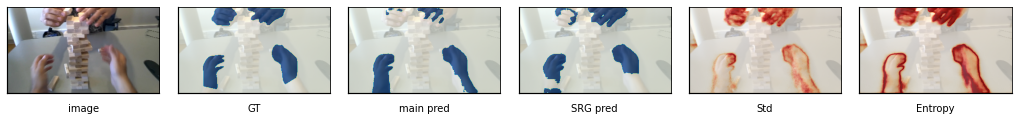

Obs. 571 processed, t_load: 0.045, t_MCS: 0.534, t_ENTP: 0.003, t_inSRG: 0.001, t_SRG: 0.099 t_sum= 0.681 (s)


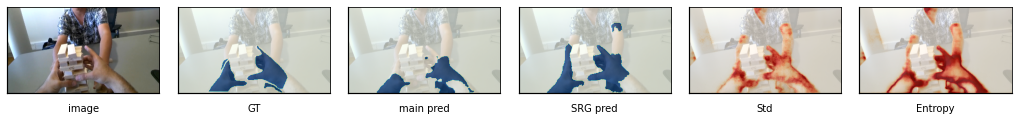

Obs. 581 processed, t_load: 0.059, t_MCS: 0.538, t_ENTP: 0.002, t_inSRG: 0.002, t_SRG: 0.097 t_sum= 0.697 (s)


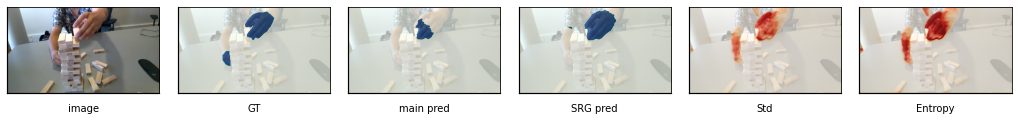

Obs. 591 processed, t_load: 0.059, t_MCS: 0.545, t_ENTP: 0.007, t_inSRG: 0.004, t_SRG: 0.112 t_sum= 0.726 (s)


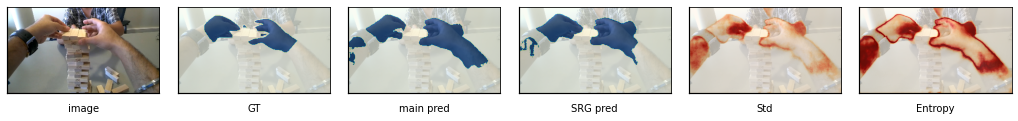

Obs. 601 processed, t_load: 0.042, t_MCS: 0.528, t_ENTP: 0.003, t_inSRG: 0.001, t_SRG: 0.098 t_sum= 0.671 (s)


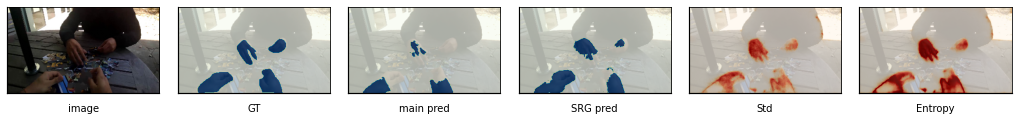

Obs. 611 processed, t_load: 0.046, t_MCS: 0.522, t_ENTP: 0.002, t_inSRG: 0.002, t_SRG: 0.097 t_sum= 0.668 (s)


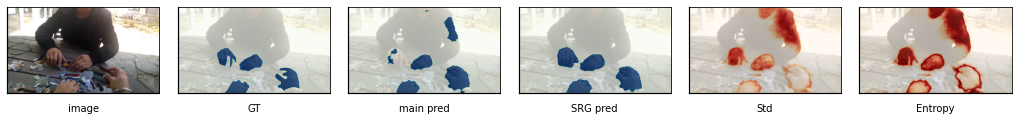

Obs. 621 processed, t_load: 0.044, t_MCS: 0.573, t_ENTP: 0.003, t_inSRG: 0.001, t_SRG: 0.099 t_sum= 0.719 (s)


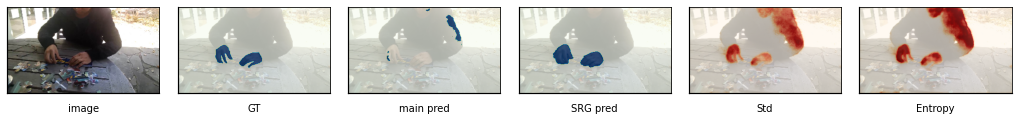

Obs. 631 processed, t_load: 0.054, t_MCS: 0.526, t_ENTP: 0.002, t_inSRG: 0.002, t_SRG: 0.098 t_sum= 0.682 (s)


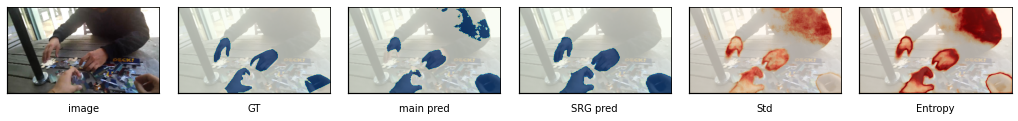

Obs. 641 processed, t_load: 0.050, t_MCS: 0.543, t_ENTP: 0.002, t_inSRG: 0.002, t_SRG: 0.098 t_sum= 0.695 (s)


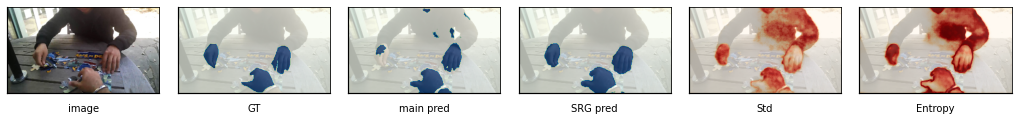

Obs. 651 processed, t_load: 0.046, t_MCS: 0.532, t_ENTP: 0.002, t_inSRG: 0.002, t_SRG: 0.096 t_sum= 0.678 (s)


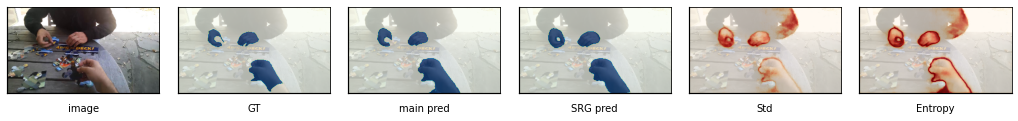

Obs. 661 processed, t_load: 0.045, t_MCS: 0.571, t_ENTP: 0.005, t_inSRG: 0.003, t_SRG: 0.107 t_sum= 0.731 (s)


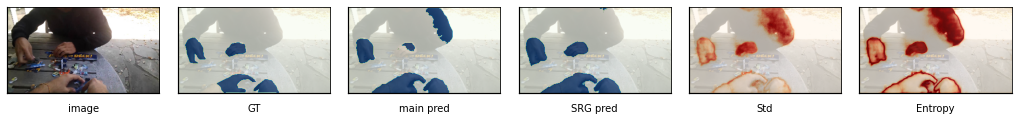

Obs. 671 processed, t_load: 0.043, t_MCS: 0.533, t_ENTP: 0.002, t_inSRG: 0.002, t_SRG: 0.098 t_sum= 0.678 (s)


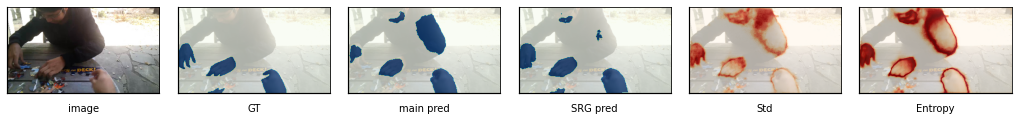

Obs. 681 processed, t_load: 0.045, t_MCS: 0.566, t_ENTP: 0.002, t_inSRG: 0.003, t_SRG: 0.096 t_sum= 0.711 (s)


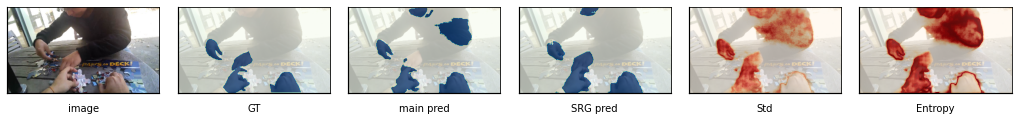

Obs. 691 processed, t_load: 0.043, t_MCS: 0.532, t_ENTP: 0.002, t_inSRG: 0.002, t_SRG: 0.112 t_sum= 0.691 (s)


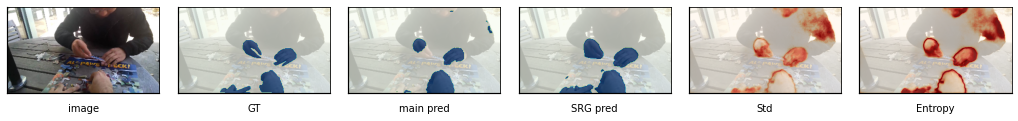

Obs. 701 processed, t_load: 0.046, t_MCS: 0.558, t_ENTP: 0.003, t_inSRG: 0.002, t_SRG: 0.099 t_sum= 0.707 (s)


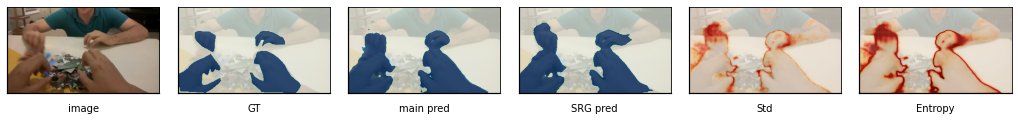

Obs. 711 processed, t_load: 0.044, t_MCS: 0.529, t_ENTP: 0.002, t_inSRG: 0.002, t_SRG: 0.097 t_sum= 0.673 (s)


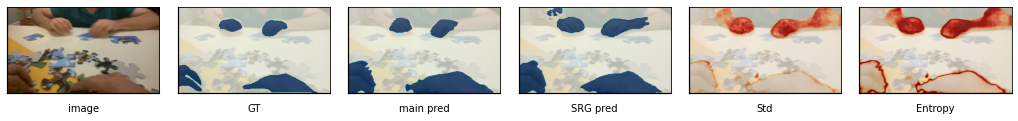

Obs. 721 processed, t_load: 0.046, t_MCS: 0.546, t_ENTP: 0.005, t_inSRG: 0.002, t_SRG: 0.098 t_sum= 0.697 (s)


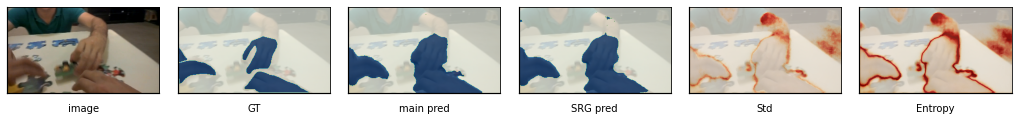

Obs. 731 processed, t_load: 0.044, t_MCS: 0.542, t_ENTP: 0.002, t_inSRG: 0.002, t_SRG: 0.100 t_sum= 0.689 (s)


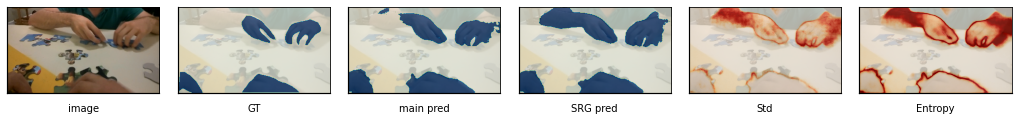

Obs. 741 processed, t_load: 0.057, t_MCS: 0.563, t_ENTP: 0.003, t_inSRG: 0.002, t_SRG: 0.098 t_sum= 0.722 (s)


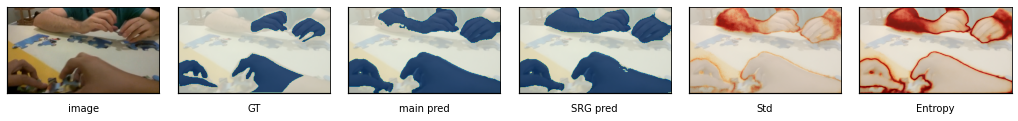

Obs. 751 processed, t_load: 0.047, t_MCS: 0.533, t_ENTP: 0.002, t_inSRG: 0.002, t_SRG: 0.098 t_sum= 0.682 (s)


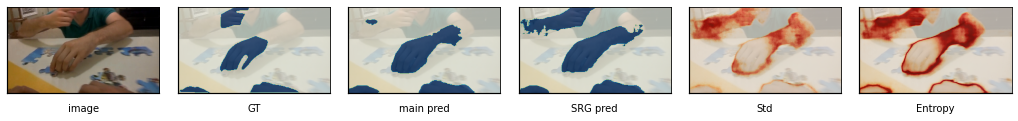

Obs. 761 processed, t_load: 0.043, t_MCS: 0.534, t_ENTP: 0.003, t_inSRG: 0.001, t_SRG: 0.100 t_sum= 0.681 (s)


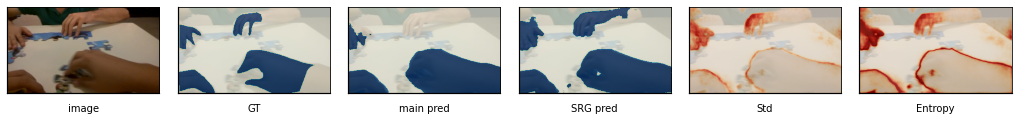

Obs. 771 processed, t_load: 0.044, t_MCS: 0.525, t_ENTP: 0.002, t_inSRG: 0.002, t_SRG: 0.113 t_sum= 0.685 (s)


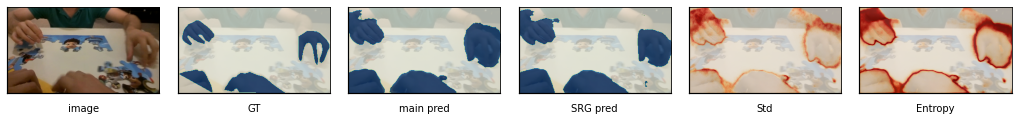

Obs. 781 processed, t_load: 0.044, t_MCS: 0.519, t_ENTP: 0.003, t_inSRG: 0.002, t_SRG: 0.098 t_sum= 0.666 (s)


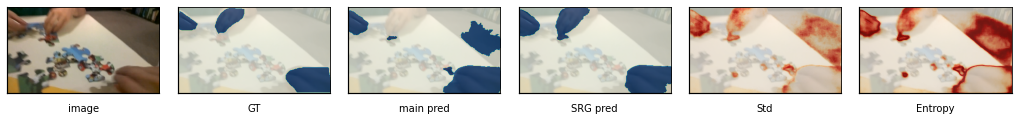

Obs. 791 processed, t_load: 0.045, t_MCS: 0.538, t_ENTP: 0.002, t_inSRG: 0.002, t_SRG: 0.099 t_sum= 0.687 (s)


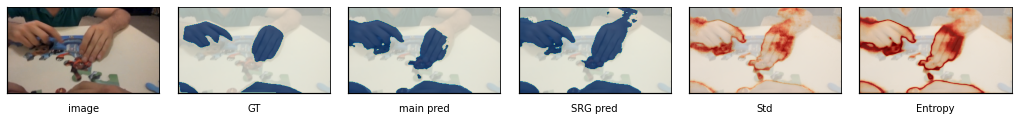

In [29]:
data_set=test_set

t_bin=[]

alpha=0.7


for i_obs in np.arange(0,800,10):
    
    t0 = time.time() ## initiate data loading 
    mask_i,img_i = data_set.load_data(i_obs,verbose=0,resize=True)
    img_i=img_i.reshape((1,)+img_i.shape)
    mask_i=mask_i.reshape((1,)+mask_i.shape)

    mask_i[mask_i>2]=2
    
    t1 = time.time() ## initiate MCS
    SoftmaxMean_main_i,SoftmaxStd_main_i=Monty_Model_softmax_X(img_i,main_model, N_MCS_main)
    
    
    
    t2 = time.time() ## entropy calcs

    p_c=SoftmaxMean_main_i
    max_p=np.sum(SoftmaxMean_main_i,axis=-1)
    max_p=np.reshape(max_p,max_p.shape+(1,))
    p_c_norm=np.divide(p_c,max_p)
    log_p_c=np.log10(p_c_norm+1e-12)
    entropy_i=np.sum(np.multiply(-1*p_c_norm,log_p_c),axis=-1)

    t3 = time.time() ## save to file
    SoftmaxStd_main_i=SoftmaxStd_main_i.reshape(1,data_set.new_H,data_set.new_W,2)
    SoftmaxMean_main_i=SoftmaxMean_main_i.reshape(1,data_set.new_H,data_set.new_W,2)
    entropy_i=entropy_i.reshape((1,data_set.new_H,data_set.new_W,1))
    X_SRG=np.concatenate((img_i,SoftmaxMean_main_i,SoftmaxStd_main_i,entropy_i),axis=-1) 

    y_pred_main=np.argmax(SoftmaxMean_main_i,axis=-1)
    
    # np.savez_compressed(set_dir+'/X_SRG_'+str(i_obs+1)+'.npz',X_SRG=X_SRG)

    t4 = time.time() ## Initiate second inference
    
    SoftmaxMean_SRG_i,SoftmaxStd_SRG_i=Monty_Model_softmax_X(X_SRG,SRG_model, N_MCS_SRG)
    
    y_pred_SRG=np.argmax(SoftmaxMean_SRG_i,axis=-1).reshape(1,data_set.new_H,data_set.new_W)
    
    t5 = time.time() ## End of inference 
    
    # times
    dt_1=t1-t0  # load data
    dt_2=t2-t1  # perform MCS
    dt_3=t3-t2  # measure entropy
    dt_4=t4-t3  # Build SRG input
    dt_5=t5-t4  # SRG inference
    t_sum=t5-t0
    
    t_bin.append([dt_1,dt_2,dt_3,dt_4,dt_5])
    print('Obs. %d processed, t_load: %1.3f, t_MCS: %1.3f, t_ENTP: %1.3f, t_inSRG: %1.3f, t_SRG: %1.3f t_sum= %1.3f (s)'%((i_obs+1,dt_1,dt_2,dt_3,dt_4,dt_5,t_sum)))
    
    fig,ax = plt.subplots(1,6,figsize=(18,3))
    plt.subplots_adjust(wspace=0.12, hspace=0.1)
    
    for i in range(6):
        ax[i].spines['top'].set_visible(1.2)
        ax[i].spines['right'].set_visible(1.2)
        ax[i].spines['bottom'].set_linewidth(1.2)
        ax[i].spines['left'].set_linewidth(1.2)
        ax[i].set_yticklabels([])
        ax[i].set_xticklabels([])
        ax[i].tick_params(bottom=False, left=False)
    
    ax[0].imshow(img_i[0])
    ax[0].set_xlabel('image')

    ax[1].imshow(img_i[0])
    ax[1].imshow(mask_i[0],alpha=alpha,cmap='GnBu')
    ax[1].set_xlabel('GT')
    
    ax[2].imshow(img_i[0])
    ax[2].imshow(y_pred_main[0],alpha=alpha,cmap='GnBu')
    ax[2].set_xlabel('main pred')

    ax[3].imshow(img_i[0])
    ax[3].imshow(y_pred_SRG[0],alpha=alpha,cmap='GnBu')
    ax[3].set_xlabel('SRG pred')
    
    ax[4].imshow(img_i[0])
    ax[4].imshow(SoftmaxStd_main_i[0,:,:,1],alpha=alpha,cmap='OrRd')
    ax[4].set_xlabel('Std')    
    
    ax[5].imshow(img_i[0])
    ax[5].imshow(entropy_i[0,:,:,0],alpha=alpha,cmap='OrRd')
    ax[5].set_xlabel('Entropy')    
    
    
    plot_save_name='test_save/'+str(i_obs+1).zfill(3)+'.png'
    fig.savefig(plot_save_name,dpi=150, pad_inches=0.1,bbox_inches='tight',facecolor='white')   
    
    plt.show()
    plt.close()

In [20]:
np.unique(mask_i)

array([1, 2], dtype=uint8)

In [21]:
class DataGenerator_B(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, set_dir, class_weights, batch_size,
                 ind_first=0,
                 ind_last=1799,
                 n_classes=2, shuffle=True, new_H=new_H, new_W=new_W):
        'Initialization'
        self.set_dir = set_dir
        self.ind_first= ind_first
        self.ind_last= ind_last
        self.batch_size = batch_size
        self.class_weights = class_weights
        self.n_obs = self.ind_last-self.ind_first+1
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        self.new_H = new_H
        self.new_W = new_W

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.n_obs / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        data_tuple = self.__data_generation(indexes)

        return data_tuple

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.ind_first,self.ind_last+1)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, self.new_H,self.new_W, 8))
        y = np.empty((self.batch_size, self.new_H,self.new_W), dtype=int)

        # Generate data
        for i, ID in enumerate(indexes):
            # Store sample
            X[i,] = np.load(self.set_dir+'/X_SRG_'+str(ID+1)+'.npz')['X_SRG'] # already normalized
            
            # Store class
            mask_i = scipy.io.loadmat(self.set_dir+'/hand_mask_'+str(ID+1)+'.mat')['hand_mask']
            y[i] = cv2.resize(np.array(mask_i), (self.new_W,self.new_H), interpolation =cv2.INTER_NEAREST)-1
         
        y[y>1]=1
        y_resh=y.reshape((-1,self.new_H*self.new_W))
#         print(np.amax(y_resh))
#         print(y_resh.shape)
        y_cat=keras.utils.to_categorical(y_resh, num_classes=self.n_classes)
        batch_wieghts = gen_weight_mat(y,self.class_weights)
        

        return (X, y_cat,batch_wieghts)

In [22]:
batch_size_eval = 40
test_generator = DataGenerator_B('../../dataset/03_test',
                               class_weights_freq,batch_size_eval,
                               ind_first=0,
                               ind_last=799,
                               shuffle=False)

In [23]:
def Monty_Model_softmax_SRG(data_generator, model, N_MCS=N_MCS,steps=int(800/batch_size_eval)):
    SoftMaxBin_list=[]
    for i in range(N_MCS):
        print(i)
        SoftMaxBin_list.append(model.model.predict_generator(data_generator,steps=steps))
    SoftMaxBin=np.array(SoftMaxBin_list)
    SoftmaxMean=np.mean(SoftMaxBin,axis=0)
    SoftmaxStd=np.std(SoftMaxBin,axis=0)
    return SoftmaxMean,SoftmaxStd

In [24]:
SoftmaxMean_test_SRG,SoftmaxStd_test_SRG = Monty_Model_softmax_SRG(test_generator,SRG_model, N_MCS=N_MCS_SRG,steps=int(800/batch_size_eval))

0


In [25]:
def Models_eval_hands_B(SoftmaxMean,y_get_set,save_fname):
    
    Y_pred=np.argmax(SoftmaxMean,axis=-1).reshape(-1,new_H,new_W)
    # precision, recall, f1
    prc_bin, rec_bin, f1_bin, _ =precision_recall_fscore_support(y_get_set.ravel(), Y_pred.ravel())
    # calculate entropy
    p_c=SoftmaxMean
    max_p=np.sum(SoftmaxMean,axis=-1)
    max_p=np.reshape(max_p,max_p.shape+(1,))
    p_c_norm=np.divide(p_c,max_p)
    log_p_c=np.log10(p_c_norm+1e-12)
    entropy=np.sum(np.multiply(-1*p_c_norm,log_p_c),axis=-1)
    
    # IoU
    classes=np.unique(y_get_set)
    nClasses=len(classes)
    IoU_bin=[]

    Mask_GT=y_get_set
    Mask_Prd=Y_pred

    for i in range(nClasses):
        
        GT_class_cond=(Mask_GT==classes[i])
        Prd_class_cond=(Mask_Prd==classes[i])
        # Measure IoU
        intersection=np.logical_and(GT_class_cond,Prd_class_cond)
        union=np.logical_or(GT_class_cond,Prd_class_cond)
        
        IoU_class = np.sum(intersection) / np.sum(union) 
        IoU_bin.append(IoU_class)    
    
    print('           Background    Hands')
    print('Precision:    %1.4f      %1.4f'%(prc_bin[0]*100,prc_bin[1]*100))
    print('Recall:       %1.4f      %1.4f'%(rec_bin[0]*100,rec_bin[1]*100))
    print('F1-score:     %1.4f      %1.4f'%(f1_bin[0]*100,f1_bin[1]*100))
    print('IoU:          %1.4f      %1.4f'%(IoU_bin[0]*100,IoU_bin[1]*100))
            
    # save to file 
    np.savez_compressed(save_fname+'.npz',prc_bin=prc_bin, rec_bin=rec_bin, f1_bin=f1_bin, IoU_bin=IoU_bin)
    

In [26]:
import glob
def get_Y(set_dir,new_H=new_H,new_W=new_W):
    obs_dir=glob.glob(set_dir+'/hand_mask_*')
    n_obs_set=len(obs_dir)
    y=np.empty((n_obs_set, new_H,new_W), dtype=int)
    for i_obs in range(n_obs_set):
        mask_i = scipy.io.loadmat(set_dir+'/hand_mask_'+str(i_obs+1)+'.mat')['hand_mask']
        y[i_obs] = cv2.resize(np.array(mask_i), (new_W,new_H), interpolation =cv2.INTER_NEAREST)-1

    y[y>1]=1
#     y_resh=y.reshape((-1,new_H*new_W))
    print(y.shape)
    return y

In [27]:
y_gt_test=get_Y('../../dataset/03_test')

(800, 180, 320)


In [28]:
Models_eval_hands_B(SoftmaxMean_test_SRG,y_gt_test,'test_metrics')

           Background    Hands
Precision:    99.4304      64.7189
Recall:       95.1447      94.2335
F1-score:     97.2403      76.7360
IoU:          94.6289      62.2534
